In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import seaborn
import pandas as pd

np.random.seed(1234)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

In [2]:
%%bash
if [ ! -d tmp ]
then
mkdir tmp
fi

# $$\text{???} = (MC)^2$$

## Background

What if we know the relative likelihood, but want the probability distribution?

$$\mathbb{P}(X=x) = \frac{f(x)}{\int_{-\infty}^\infty f(x)dx}$$

But what if $\int f(x)dx$ is hard, or you can't sample from $f$ directly?

This is the problem we will be trying to solve.

## First approach
If space if bounded (integral is between $a,b$) we can use Monte Carlo to estimate $\int\limits_a^b f(x)dx$

- Pick $\alpha \in (a,b)$
- Compute $f(\alpha)/(b-a)$
- Repeat as necessary
- Compute the expected value of the computed values

## What if hard?
What if we can't sample from $f(x)$ but can only determine likelihood ratios?

$$\frac{f(x)}{f(y)}$$

### Markov Chain Monte Carlo

# The obligatory basics
A **Markov Chain** is a stochastic process (a collection of indexed random variables) such that $\mathbb{P}(X_n=x|X_0,X_1,...,X_{n-1}) = \mathbb{P}(X_n=x|X_{n-1})$.

In other words, the conditional probabilities only depend on the last state, not on any deeper history.

We call the set of all possible values of $X_i$ the **state space** and denote it by, $\chi$.

### Transition Matrix
Let $p_{ij} = \mathbb{P}(X_1 = j | X_0 = i)$. We call the matrix $(p_{ij})$ the **Transition Matrix** of $X$ and denote it $P$.

Let $\mu_n = \left(\mathbb{P}(X_n=0), \mathbb{P}(X_n=1),..., \mathbb{P}(X_n=l)\right)$ be the row vector corresponding to the "probabilities" of being at each state at the $n$th point in time (iteration).

Claim: $\mu_{i+1} = \mu_0P^{i+1}$

$$\begin{align*}
(\mu_0 P)_j =& \sum\limits_{i=1}^l\mu_0(i)p_{ij}\\
=&\sum\limits_{i=1}^l\mathbb{P}(X_0=i)\mathbb{P}(X_1=j | X_0=i)\\
=&\mathbb{P}(X_1 = j)\\
=&\mu_1(j)
\end{align*}$$

So: $\mu_1 = \mu_0P$.

### Stationary Distributions
We say that a distribution $\pi$ is **stationary** if

$$\begin{gather*}\pi P = \pi\end{gather*}$$

### Limiting Distribution?

### Main Theorem:
An irreducible, ergotic Markov Chain $\{X_n\}$ has a unique stationary distribution, $\pi$. The limiting distribution exists and is equal to $\pi$. And furthermore, if $g$ is any bounded function, then with probability 1:

### $$\lim\limits_{N\to\infty}\frac{1}{N}\sum\limits_{n=1}^Ng(X_n) \rightarrow E_\pi(g)$$

## Random-Walk-Metropolis - Hastings:
Let $f(x)$ be the relative likelihood function of our desired distribution.

$q(y|x_i)$ known distribution easily sampled from (generally taken to be $N(x_i,b^2)$)

1) Given $X_0,X_1,...,X_i$, pick $Y \sim q(y|X_i)$

2) Compute $r(X_i,Y) = \min\left(\frac{f(Y)q(X_i|Y)}{f(X_i)q(Y|X_i)}, 1\right)$

3) Pick $a \sim U(0,1)$

4) Set $X_{i+1} = \begin{cases} Y & \text{if } a < r \\
X_i & \text{otherwise}\end{cases}$

## The Confidence Builder:
We would like to sample from and obtain a histogram of the Cauchy distribution:

$$f(x) = \frac{1}{\pi}\frac{1}{1+x^2}$$

$$\begin{align*}
q_{01} \sim& N(x,0.1)\\
q_1 \sim& N(x,1)\\
q_{10} \sim& N(x,10)\end{align*}$$

Note: Since $q$ is symmetric, $q(x|y) = q(y|x)$!

In [3]:
def metropolis_hastings(f, q, initial_state, num_iters):
    """
    Generate a Markov Chain Monte Carlo using
    the Metropolis-Hastings algorithm.
    
    Parameters
    ----------
    f : function
        the [relative] likelood function for
        the distribution we would like to
        approximate
    q : function
        The conditional distribution to be
        sampled from (given an X_i, sample
        from q(X_i) to get potential X_i+1)
    initial_state : type accepted by f,q
        The initial state. This state will
        not be included as part of the 
        Markov Chain.
    num_iters : int or float
        the number of desired iterations
        float is included to facilitate
        1e5 type use
    
    Returns
    -------
    out : Python Array
        Array where out[i] = X_{i-1} because
        X_0 (the initial state) is not included
    """
    MC = []
    X_i = initial_state
    for i in range(int(num_iters)):
        Y = q(X_i)
        r = min(f(Y)/f(X_i), 1)
        a = np.random.uniform()
        if a < r:
            X_i = Y
        MC.append(X_i)
    return MC

In [4]:
def cauchy_dist(x):
    return 1/(np.pi*(1 + x**2))
def q(scale):
    return lambda x: np.random.normal(loc=x, scale=scale)

In [5]:
from scipy.stats import cauchy
CauchyInterval = np.linspace(cauchy.ppf(0.01),
                             cauchy.ppf(0.99),
                             100);

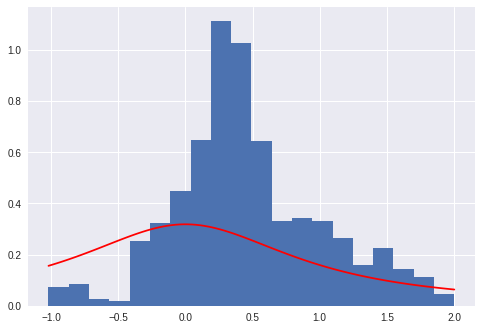

In [6]:
plt.figure(1);
plt.subplot(3,1,1);
plt.title("STD = 0.1")
std01 = metropolis_hastings(cauchy_dist, q(0.1), 0, 1000)
tmpHist = plt.hist(std01, bins=20, normed=True);
tmpLnSp = np.linspace(min(tmpHist[1]),
                      max(tmpHist[1]),100)
plt.plot(tmpLnSp, cauchy.pdf(tmpLnSp), 'r-')
plt.subplot(3,1,2)
plt.title("STD = 1")
std1 = metropolis_hastings(cauchy_dist, q(1), 0, 1000)
tmpHist = plt.hist(std1, bins=20, normed=True);
tmpLnSp = np.linspace(min(tmpHist[1]),
                      max(tmpHist[1]),100)
plt.plot(tmpLnSp, cauchy.pdf(tmpLnSp), 'r-')
plt.subplot(3,1,3)
plt.title("STD = 10")
std10 = metropolis_hastings(cauchy_dist, q(10), 0, 1000)
tmpHist = plt.hist(std10, bins=20, normed=True);
tmpLnSp = np.linspace(min(tmpHist[1]),
                      max(tmpHist[1]),100)
plt.plot(tmpLnSp, cauchy.pdf(tmpLnSp), 'r-')
plt.tight_layout()
plb.savefig("tmp/18-MCMC-Cauchy-Estimation.png")
plb.savefig("../../../pics/2017/04/18-MCMC-Cauchy-Estimation.png");
plt.show()

## Estimation:

$$q(y|x) \sim N(0,b^2)$$

![The many distributions](tmp/18-MCMC-Cauchy-Estimation.png "Title?")

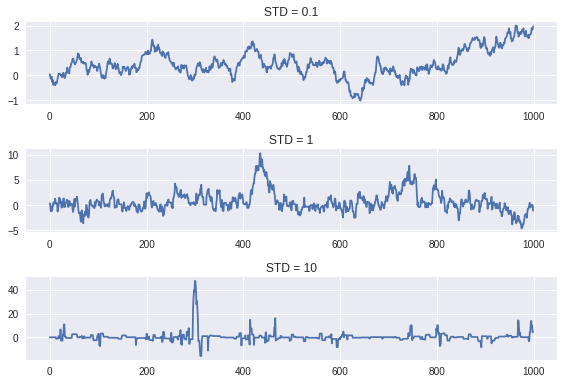

In [10]:
plt.figure(2)
plt.subplot(3,1,1)
plt.title("STD = 0.1")
plt.plot(std01)
plt.subplot(3,1,2)
plt.title("STD = 1")
plt.plot(std1)
plt.subplot(3,1,3)
plt.title("STD = 10")
plt.plot(std10)
plt.tight_layout()
plb.savefig("tmp/18-MCMC-Cauchy-Estimation_TS.png")
plb.savefig("../../../pics/2017/04/18-MCMC-Cauchy-Estimation_TS.png")
plt.show()

## Another Aspect

![Other things](tmp/18-MCMC-Cauchy-Estimation_TS.png)

## How is this happening???

A property called **detailed balance**, which means,
$$\pi_ip_{ij} = p_{ji}\pi_j$$

or in the continuous case:
$$f(x)P_{xy} = f(y)P_{yx}$$

But we don't need to go over that... Unless you wanna...

### Proof?
Let $f$ be the desired distribution (in our example, it was the Cauchy Distribution), and let $q(y|x)$ be the distribution we draw from.

First we'll show that detailed balance implies $\pi$ (or $f$ if continuous) is the stable distribution!

Let $\pi_ip_{ij} = \pi_jp_{ji}$ for discrete or for continuous $f(i)P_{ij}=P_{ji}f(j)$

$$\begin{align*}
(\pi P)_i =& \sum\limits_j\pi_jP_{ji} & (fP)(x)=&\int f(y)p(x|y)dy\\
=&\sum\limits_j\pi_iP_{ij} & =& \int f(x)p(y|x)dy\\
=&\pi_i\sum\limits_jP_{ij} & =& f(x)\int p(y|x)dy\\
=&\pi_i & =& f(x)
\end{align*}$$

Now we'll show that our MCMC has the detailed balance property.

WLOG: Assume $f(x)q(y|x) > f(y)q(x|y)$.

Note: $r(x,y) = \frac{f(y)q(x|y)}{f(x)q(y|x)}$, and $r(y,x) = 1$.

Then,

$$\begin{align*}
\pi_xp_{xy} =& f(x)\mathbb{P}(X_1=y|X_0=x) & \pi_yp_{yx} =& f(y)\mathbb{P}(X_1=x|X_0=y)\\
=& f(x)\left[q(y|x)\cdot r(x,y)\right] & =&f(y)\left[q(x|y)\cdot r(y,x)\right]\\
=& f(x)\left[q(y|x)\cdot \frac{f(y)q(x|y)}{f(x)q(y|x)}\right] & =&f(y)\left[q(x|y)\cdot 1\right]\\
=& f(y)q(x|y) & =&f(y)q(x|y)
\end{align*}$$

### The intuition

We want equal hopportunity:

$$f(x)p(y|x) = f(y)p(x|y)$$

$$r(x,y) = \min\left(\frac{f(y)q(x|y)}{f(x)q(y|x)},1\right)$$

## Modeling Change Point Models in Astrostatistics.

$$
\begin{align*}
f(k,\theta,\lambda,b_1,b_2 | Y) \alpha& \prod\limits_{i=1}^k\frac{\theta^{Y_i}e^{-\theta}}{Y_i!} \prod\limits_{i=k+1}^n\frac{\lambda^{Y_i}e^{-\lambda}}{Y_i!} \\
&\times\frac{1}{\Gamma(0.5)b_1^{0.5}}\theta^{-0.5}e^{-\theta/b_1} \times\frac{1}{\Gamma(0.5)b_2^{0.5}}\theta^{-0.5}e^{-\theta/b_2}\\
&\times\frac{e^{-1/b_1}}{b_1}\frac{e^{-1/b_2}}{b_2}\times \frac{1}{n}
\end{align*}
$$

In [11]:
def psu_mcmc(X, q, numIters=10000):
    theta, lambd, k, b1, b2 = 1, 1, 20, 1, 1
    thetas, lambds, ks, b1s, b2s = [], [], [], [], []
    n = len(X)
    def f_k(theta, lambd, k, b1, b2):
        if 0 <= k and k <= n:
            return theta**sum(X[:k])*lambd**sum(X[k:])*np.exp(-k*theta-(n-k)*lambd)
        elif k < 0:
            return lambd**sum(X)*np.exp(-n*lambd)
        elif k > n:
            return theta**sum(X)*np.exp(-n*theta)
    def f_t(theta, k, b1):
        return theta**(sum(X[:k])+0.5)*np.exp(-theta*(k+1.0)/b1)
    def f_l(lambd, k, b2):
        return lambd**(sum(X[k:])+0.5)*np.exp(-lambd*((n-k)+1.0)/b2)
    def f_b(b, par):
        return np.exp(-(1 + par) / b) / (b*np.sqrt(b))
    for i in range(numIters):
        tmp = q(theta)
        if tmp < np.infty:
            r = min(1, f_t(tmp,k,b1)/f_t(theta,k,b1))
            if np.random.uniform(0,1) < r:
                theta = tmp
        tmp = q(lambd)
        if tmp < np.infty:
            r = min(1, f_l(tmp,k,b2)/f_l(lambd,k,b2))
            if np.random.uniform(0,1) < r:
                lambd = tmp
        tmp = q(b1)
        if tmp < np.infty:
            r = min(1, f_b(tmp, theta)/f_b(b1, theta))
            if np.random.uniform(0,1) < r:
                b1 = tmp
        tmp = q(b2)
        if tmp < np.infty:
            r = min(1, f_b(tmp, lambd)/f_b(b2, lambd))
            if np.random.uniform(0,1) < r:
                b2 = tmp
        tmp = q(k)
        if tmp < np.infty:
            r = min(1, f_k(theta, lambd, tmp, b1, b2) /
                    f_k(theta, lambd, k, b1,b2))
            if np.random.uniform(0,1) < r:
                k = tmp
        thetas.append(theta)
        lambds.append(lambd)
        b1s.append(b1)
        b2s.append(b2)
        ks.append(k)
    return np.array([thetas,lambds,ks,b1s,b2s])

In [12]:
%%bash
if [ ! -f tmp/psu_data.tsv ]
then
wget http://sites.stat.psu.edu/~mharan/MCMCtut/COUP551_rates.dat -O tmp/psu_data.tsv
fi

In [13]:
psu_data = []
with open("tmp/psu_data.tsv", "r") as f:
    title = f.readline()
    for line in f:
        tmpArr = [x.strip() for x in line.split(" ")]
        psu_data.append([int(x) for x in tmpArr if x != ""][1])
psu_data = np.array(psu_data)
psu_data

array([11,  3,  5,  9,  3,  4,  5,  5,  5,  5, 13, 18, 27,  8,  4, 10,  8,
        3, 12, 10, 10,  3,  9,  8,  5,  9,  4,  6,  1,  5, 14,  7,  9, 10,
        8, 13,  8, 11, 11, 10, 11, 13, 10,  3,  8,  5])

/home/amniskin/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/amniskin/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/amniskin/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/amniskin/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in sqrt
/home/amniskin/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in double_scalars
/home/amniskin/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: overflow encountered in double_scalars
/home/amniskin/anacon

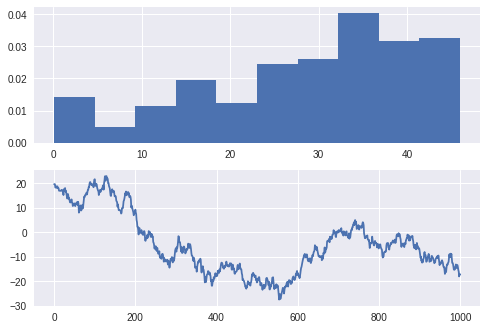

In [14]:
mcmc2 = psu_mcmc(psu_data, q(1), 1000)
plt.figure()
plt.subplot(2,1,1)
plt.hist(mcmc2[2] % len(psu_data), normed=True)
plt.subplot(2,1,2)
plt.plot(mcmc2[2])
plt.show();

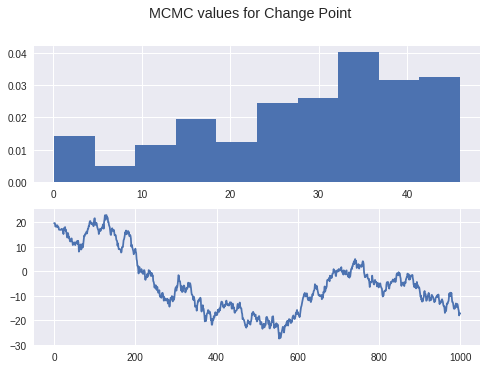

In [17]:
fig = plt.figure()
fig.suptitle("MCMC values for Change Point")
plt.subplot(2,1,1)
plt.hist(mcmc2[2] % len(psu_data), normed=True)
plt.subplot(2,1,2)
plt.plot(mcmc2[2])
plb.savefig("tmp/psu_graphs1.png")
plt.show()

![Not so useful](tmp/psu_graphs1.png)

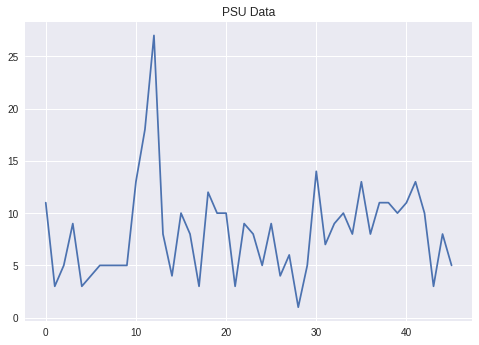

In [19]:
plt.plot(psu_data)
plt.title("PSU Data")
plb.savefig("tmp/psu_ts.png")
plt.show()

![](tmp/psu_ts.png)

[stat.psu.edu](http://sites.stat.psu.edu/~mharan/MCMCtut/COUP551_rates.dat)

### Potential Issues with RWMetropolis-Hastings:

- Requires $f$ to be defined on all of $\mathbb{R}$
    - So transform as needed
- Curse of dimensionality in tuning parameters

## Other forms

- Gibbs Sampling
    - Turn high dimensional sampling into iterative one-dimensional sampling

- Gibbs with Metropolis-Hastings

## Bibliography
[Summer School in Astrostatistics](http://sites.stat.psu.edu/~mharan/MCMCtut/MCMC.html)